# Simulating laser intensity fluctuation 

In [1]:
import numpy as np
import pandas as pd
import scipy.special
import scipy.optimize
import matplotlib.pyplot as plt
import pboc.plotting 
import statsmodels.tools.numdiff as smnd
colors = pboc.plotting.set_plotting_style()
%matplotlib inline

In [21]:
# Partition the proteins.
n_div = 600 
n_tot = np.random.gamma(1, 100, size=n_div).astype(int)
n_1 = np.random.binomial(n_tot, p=0.5, size=n_div)
n_2 = n_tot - n_1

# Set up different cases of alpha. 
alpha_fixed = 100 
err = 0.05
alpha_cell = np.random.normal(loc=alpha_fixed, scale=err * alpha_fixed, size=n_div)
i1_fixed = alpha_fixed * n_1
i2_fixed = alpha_fixed * n_2
i1_cell = alpha_cell * n_1
i2_cell = alpha_cell * n_2

i1_prot = np.array([(np.random.normal(loc=alpha_fixed, scale=err * alpha_fixed, size=a) + np.random.normal(loc=0, scale=100, size=a)).sum() for a in n_1])
i2_prot = np.array([(np.random.normal(loc=alpha_fixed, scale=err * alpha_fixed, size=a) + np.random.normal(loc=0, scale=100, size=a)).sum() for a in n_2])

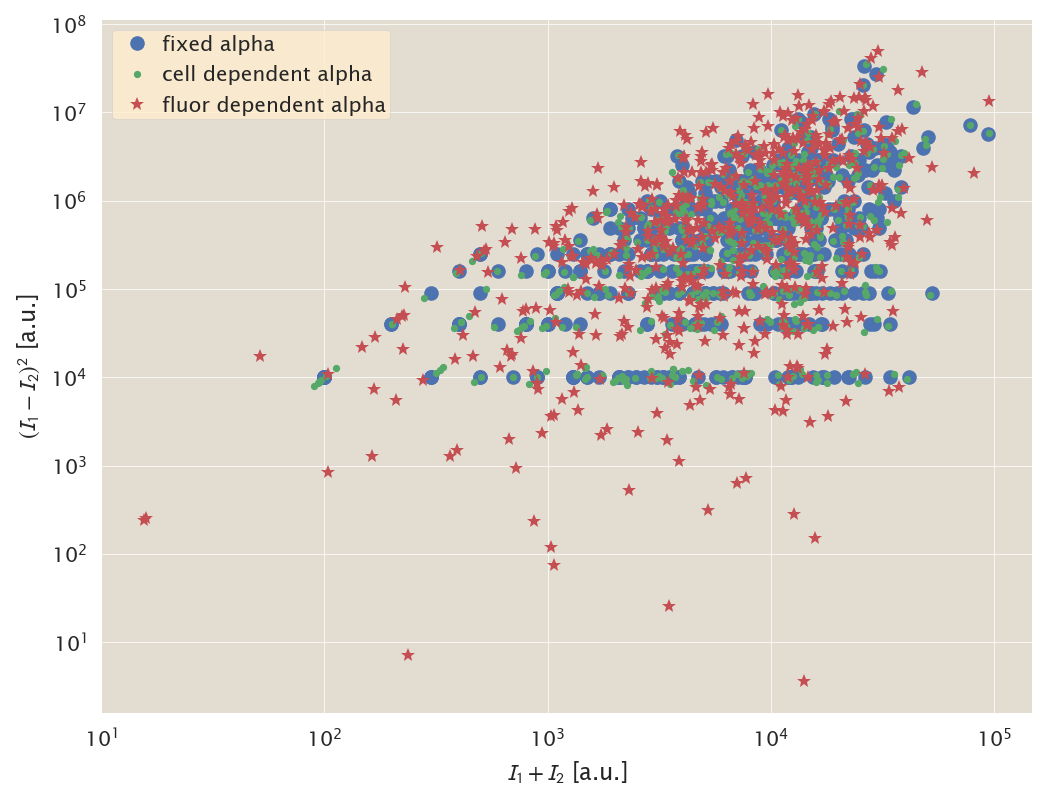

In [22]:
# Plot all of the scatter plots together. 
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_1 + I_2$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')
_ = ax.plot(i1_fixed + i2_fixed, (i1_fixed - i2_fixed)**2, 'o', label='fixed alpha')
_ = ax.plot(i1_cell + i2_cell, (i1_cell - i2_cell)**2, '.', label='cell dependent alpha')
_ = ax.plot(i1_prot + i2_prot, (i1_prot - i2_prot)**2, '*', label='fluor dependent alpha')
_ = ax.legend()

It's interesting to see that in the fluorophore dependent alpha case, we see many small fluctuations than you do in either of the two cases.

Now let's try to estimate the calibration factor in each case. 

In [23]:


def deterministic_log_post(alpha, I1, I2, p=0.5, neg=True):
    """
    Computes the log posterior for the deterministic measurement
    of the calibration factor α.

    Parmeters
    ---------
    alpha : float or int
        The calibration factor in units of A.U per molecule. This parameter
        must be positive.
    I1, I2 : arrays of floats or ints.
        The intensities of the two daugher cells. Each should be provided
        individually as 1d-arrays.
    p : float
        The probability of partitioning proteins into the first daughter cell.
        Defalt value is 0.5.
    neg : bool
        If True, the negative log posterior will be returned.

    Returns
    -------
    log_post: 1d-array
        The value of the log posterior at a given value of α.
    """
    # Ensure positivity of samples.
    if alpha < 0:
        return -np.inf
    if p < 0 or p > 1:
        raise RuntimeError('p must be between 0 and 1.')

    # Set the prior
    k = len(I1)
    prior = -k * np.log(alpha)

    # Determine the protein copy numbers deterministically.
    n1 = I1 / alpha
    n2 = I2 / alpha
    ntot = n1 + n2

    # Compute the binomial coefficient using log gamma functions.
    binom = scipy.special.gammaln(ntot + 1).sum() -\
        scipy.special.gammaln(n1 + 1).sum() - \
        scipy.special.gammaln(n2 + 1).sum()

    # Compute the probability factor of the binomial.
    prob = n1.sum() * np.log(p) + n2.sum() * np.log(1 - p)

    # Determine if the negative log posterior is desired.
    if neg is True:
        prefactor = -1
    else:
        prefactor = 1

    # Return the desired quantity.
    return prefactor * (prior + prob + binom)




def estimate_calibration_factor(I1, I2, p=0.5):
    """
    Estimates the optimal value of α for a given data set by minimization.

    Parameters
    ----------
    I1, I2 : 1d-arrays
        The intensities of the two daughter cells. These should be provided
        individually as 1d-arrays.
    p : float
        The probability of paritioning into the first daughter cell. Default
        value is even, 0.5.

    Returns
    -------
    alpha_opt : float
        Best-fit value for the value of α in units of A.U. per molecule.
    sd : float
        The standard deviation of the the gaussian approximation of the
        posterior.
    """

    # Minimize the negative log posterior.
    popt = scipy.optimize.minimize_scalar(deterministic_log_post,
                                          args=(I1, I2, p, True))
    alpha_opt = popt.x

    # Compute the hessian.
    hess = smnd.approx_hess([alpha_opt], deterministic_log_post,
                            args=(I1, I2, p, False))
    cov = -np.linalg.inv(hess)
    sd = np.sqrt(cov[0])

    return [alpha_opt, sd[0]]


In [24]:
fixed_cal, fixed_err = estimate_calibration_factor(i1_fixed, i2_fixed)
cell_cal, cell_err = estimate_calibration_factor(i1_cell, i2_cell)
fluor_cal, fluor_err = estimate_calibration_factor(i1_prot, i2_prot)

In [25]:
print(fixed_cal, fixed_err)

92.5923362758 5.18206410316


In [26]:
print(cell_cal, cell_err)

92.6042951392 5.18285230065


In [27]:
print(fluor_cal, fluor_err)

183.076771644 9.97302771923
